In [4]:
import random
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numba import njit, prange
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from WoLF_lib import *

ModuleNotFoundError: No module named 'WoLF_lib'

In [3]:
@njit
def select_price_WoLF(epsilon, price_grid, current_state, policy):
    u = np.random.uniform(0,1)
    if epsilon > u:
        return np.random.choice(price_grid)
    else:
        cumsum = np.cumsum(policy[np.where(price_grid == current_state)[0][0], :])
        idx = np.searchsorted(cumsum, np.array([u]))[0]
        return price_grid[idx]

In [ ]:
@njit
def WoLF_PHC(alpha, delta, gamma, price_grid, T):
    # Initializing values
    epsilon = calculate_epsilon(T)
    #print(epsilon)
    i = 0
    j = 1
    t = 0
    # Initializing Q-functions
    k = len(price_grid)
    q1 = np.zeros((k, k)) 
    q2 = np.zeros((k, k)) 
    # Initializing policies
    policy_1 = np.ones((k, k)) / k
    policy_2 = np.ones((k, k)) / k
    # Initializing average policies
    avg_policy1 = np.ones((k, k)) / k
    avg_policy2 = np.ones((k, k)) / k
    # Initializing N, a counter
    N1 = np.zeros(k)
    N2 = np.zeros(k)
    # Initializing profits
    p_table = np.zeros((2,T))
    profits = np.zeros((2,T))
    avg_profs1 = []
    avg_profs2 = []

    # Setting random price and state for t = 0
    p_table[i,t] = np.random.choice(price_grid)
    p_table[j,t] = np.random.choice(price_grid)
    
    t += 1
    # Setting random price and state for t = 1
    p_table[i,t] = np.random.choice(price_grid)
    p_table[j,t] = np.random.choice(price_grid)

    for t in range(t, T-1):
        p_table[i,t] = p_table[i,t-1]
        profits[i,t] = profit(p_table[i,t], p_table[j,t-1])
        profits[i,t+1] = profit(p_table[i,t], p_table[j,t])
        r_t = profits[i,t] + gamma * profits[i,t+1]
        p_idx = np.where(price_grid == p_table[i,t])[0][0]
        s_next_idx = np.where(price_grid == p_table[j,t])[0][0]
        current_state_idx = np.where(price_grid == p_table[j,t-1])[0][0]
        max_Q = max(q1[s_next_idx, :])
        q1[current_state_idx, p_idx] = q1[current_state_idx, p_idx] + alpha * (r_t + gamma**2 * max_Q - q1[current_state_idx, p_idx])
        # Update counter for visited state
        N1[current_state_idx] += 1
        # Update policy
        #print(avg_policy1[current_state_idx, :])
        avg_policy1[current_state_idx, :] = avg_policy1[current_state_idx, :] + (1 / N1[current_state_idx]) * (policy_1[current_state_idx, :] - avg_policy1[current_state_idx, :])
        avg_policy1[current_state_idx, :] /= avg_policy1[current_state_idx, :].sum() # To ensure a legal probability distribution
            
        if np.sum(q1[current_state_idx, :] * policy_1[current_state_idx, :]) > np.sum(q1[current_state_idx, :] * avg_policy1[current_state_idx, :]):
            delta_now = delta[0]
        else:
            delta_now = delta[1]
        #p_max_idx=np.argmax(q1[current_state_idx, :])
        #delta_sa = np.zeros(k)
        
        delta_sa = np.zeros(k) - delta_now / (k - 1)
        p_max_idx = np.argmax(q1[current_state_idx, :])
        delta_sa[p_max_idx] = - (delta_sa.sum() - delta_sa[p_max_idx])
        policy_1[current_state_idx, :] += delta_sa
        policy_1[current_state_idx, :] = np.minimum(1, np.maximum(policy_1[current_state_idx, :], 0))
        policy_1[current_state_idx, :] /= policy_1[current_state_idx, :].sum()
        p_table[i,t+1] = select_price_WoLF(epsilon[t], price_grid, p_table[j,t], policy_1)
        profits[i, t] = profit(p_table[i,t], p_table[j,t])
        profits[j, t] = profit(p_table[j,t], p_table[i,t])
         # Compute profits
        if t % 1000 == 0:
            profitability = np.sum(profits[i, (t-1000):t])/1000
            avg_profs1.append(profitability)
            profitability = np.sum(profits[j, (t-1000):t])/1000
            avg_profs2.append(profitability)
        i,j=j,i
        q1,q2=q2,q1
        policy_1,policy_2=policy_2,policy_1
        avg_policy1,avg_policy2=avg_policy2,avg_policy1
        N1,N2=N2,N1
         
    return avg_profs1, avg_profs2

            






In [5]:
@njit
def WoLF_PHC(alpha, delta, gamma, price_grid, T):
    # Initializing values
    epsilon = calculate_epsilon(T)
    #print(epsilon)
    i = 0
    j = 1
    t = 0
    # Initializing Q-functions
    k = len(price_grid)
    q1 = np.zeros((k, k)) 
    q2 = np.zeros((k, k)) 
    # Initializing policies
    policy_1 = np.ones((k, k)) / k
    policy_2 = np.ones((k, k)) / k
    # Initializing average policies
    avg_policy1 = np.ones((k, k)) / k
    avg_policy2 = np.ones((k, k)) / k
    # Initializing N, a counter
    N1 = np.zeros(k)
    N2 = np.zeros(k)
    # Initializing profits
    p_table = np.zeros((2,T))
    profits = np.zeros((2,T))
    avg_profs1 = []
    avg_profs2 = []

    # Setting random price and state for t = 0
    p_table[i,t] = np.random.choice(price_grid)
    p_table[j,t] = np.random.choice(price_grid)
    
    t += 1
    # Setting random price and state for t = 1
    p_table[i,t] = np.random.choice(price_grid)
    p_table[j,t] = np.random.choice(price_grid)

    for t in range(t, T-1):
        p_table[i,t] = p_table[i,t-1]
        profits[i,t] = profit(p_table[i,t], p_table[j,t-1])
        profits[i,t+1] = profit(p_table[i,t], p_table[j,t])
        r_t = profits[i,t] + gamma * profits[i,t+1]
        p_idx = np.where(price_grid == p_table[i,t])[0][0]
        s_next_idx = np.where(price_grid == p_table[j,t])[0][0]
        current_state_idx = np.where(price_grid == p_table[j,t-1])[0][0]
        max_Q = max(q1[s_next_idx, :])
        q1[current_state_idx, p_idx] = q1[current_state_idx, p_idx] + alpha * (r_t + gamma**2 * max_Q - q1[current_state_idx, p_idx])
        # Update counter for visited state
        N1[current_state_idx] += 1
        # Update policy
        #print(avg_policy1[current_state_idx, :])
        avg_policy1[current_state_idx, :] = avg_policy1[current_state_idx, :] + (1 / N1[current_state_idx]) * (policy_1[current_state_idx, :] - avg_policy1[current_state_idx, :])
        avg_policy1[current_state_idx, :] /= avg_policy1[current_state_idx, :].sum() # To ensure a legal probability distribution
            
        if np.sum(q1[current_state_idx, :] * policy_1[current_state_idx, :]) > np.sum(q1[current_state_idx, :] * avg_policy1[current_state_idx, :]):
            delta_now = delta[0]
        else:
            delta_now = delta[1]
        #p_max_idx=np.argmax(q1[current_state_idx, :])
        #delta_sa = np.zeros(k)
        
        delta_sa = np.zeros(k) - delta_now / (k - 1)
        p_max_idx = np.argmax(q1[current_state_idx, :])
        delta_sa[p_max_idx] = - (delta_sa.sum() - delta_sa[p_max_idx])
        policy_1[current_state_idx, :] += delta_sa
        policy_1[current_state_idx, :] = np.minimum(1, np.maximum(policy_1[current_state_idx, :], 0))
        policy_1[current_state_idx, :] /= policy_1[current_state_idx, :].sum()
        p_table[i,t+1] = select_price_WoLF(epsilon[t], price_grid, p_table[j,t], policy_1)
        profits[i, t] = profit(p_table[i,t], p_table[j,t])
        profits[j, t] = profit(p_table[j,t], p_table[i,t])
         # Compute profits
        if t % 1000 == 0:
            profitability = np.sum(profits[i, (t-1000):t])/1000
            avg_profs1.append(profitability)
            profitability = np.sum(profits[j, (t-1000):t])/1000
            avg_profs2.append(profitability)
        i,j=j,i
        q1,q2=q2,q1
        policy_1,policy_2=policy_2,policy_1
        avg_policy1,avg_policy2=avg_policy2,avg_policy1
        N1,N2=N2,N1
         
    return avg_profs1, avg_profs2

            






In [6]:
k=6
p_grid=np.round(np.arange(k + 1) / (np.zeros(k + 1) + k), 3)
prof1,prof2=WoLF_PHC(0.3, (0.2,0.6), 0.95, p_grid, 500000)    

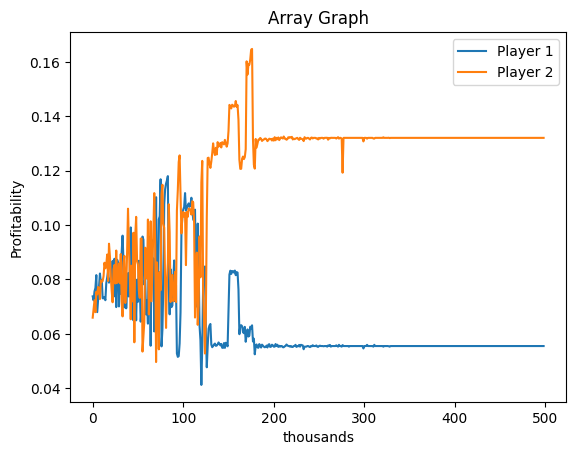

In [7]:
x_values = range(len(prof1))

# Plot the array as a line graph
plt.plot(x_values, prof1)
plt.plot(x_values, prof2)

# Add labels and title
plt.xlabel('thousands')
plt.ylabel('Profitability')
plt.title('Array Graph')
plt.legend(['Player 1', 'Player 2'])

# Display the graph
plt.show()

In [8]:
#@njit
def run_sim_wolfphc(runs, k, method='klein'):
    
    num_calcs=int(500000/1000-1)
    summed_avg_profitabilities = np.zeros(num_calcs)
    for n in range(0, runs):
        avg_profs1, avg_profs2 = WoLF_PHC(0.3, (0.2,0.6), 0.95, k, 500000)
        per_firm_profit = np.sum([avg_profs1, avg_profs2], axis=0)/2
        summed_avg_profitabilities = np.sum([summed_avg_profitabilities, per_firm_profit], axis=0)

    avg_avg_profitabilities = np.divide(summed_avg_profitabilities, runs)
    return avg_avg_profitabilities

In [14]:
avg_prof= run_sim_wolfphc(100, np.linspace(0,1,7))

NameError: name 'avg_prof' is not defined

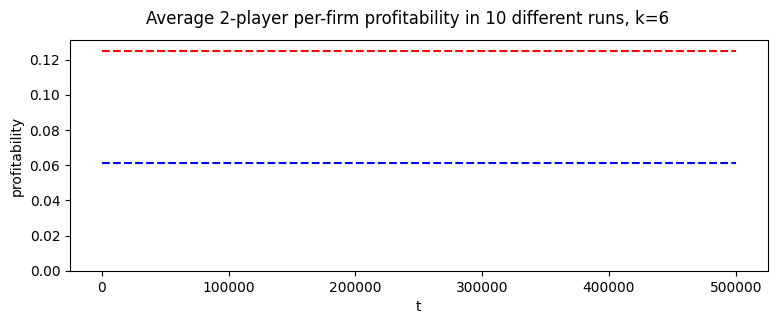

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(9,3))
fig.suptitle("Average 2-player per-firm profitability in {} different runs, k={}".format(10, 6))
axs.set_xlabel("t")
axs.set_ylabel("profitability")
xs = np.linspace(0, 500000, 499)
axs.set_ylim(0.00, 0.125+(0.125*0.05))
axs.hlines(0.125, xmin=xs[0], xmax=xs[-1], colors='red', linestyles='dashed', label='Joint profit maximizing')
axs.hlines(0.0611, xmin=xs[0], xmax=xs[-1], colors='blue', linestyles='dashed', label='Comp Benchmark/edgeworth cycle')#konstant taget fra johanne og morten
axs.plot(xs, avg_prof, color="steelblue", label = "avg. profitability")
axs.legend()  # Show the legend to display the label of the newly added line
plt.show()

In [29]:
avg_prof[498]

0.1070138888888899

# Q-learning vs WolF-PHC

In [10]:
@njit
def Q_func(p_curr_idx, s_curr_idx, i, j, t, alpha, delta, p_table, Q_table, price_grid, s_next) -> float: # p_table contains p and s (opponent price)
    """
    args:
        p_curr_idx: current price of player i
        s_curr_idx: current state of player i
        i: player 0
        j: player 1
        t: current period
        alpha: step-size parameter
        delta: discount factor
        p_table: 2x500.000 array storing prices for player 0 and 1
        Q_table: current Q_table for player i
        price_grid: price_grid
        s_next: next state for player i
    returns:
        updated value for Q_table 
    """
    prev_est = Q_table[p_curr_idx, s_curr_idx]
    s_next_index=np.where(price_grid == s_next)[0][0]
    maxed_Q = max(Q_table[s_next_index,:])
    new_est = profit(p_table[i, t], p_table[j, t-1]) + delta * profit(p_table[i, t], s_next) + delta**2 * maxed_Q
    return (1 - alpha) * prev_est + alpha * new_est

    

In [11]:

#@njit
def WoLF_PHC_vs_Q_learner(alpha, delta, gamma, price_grid, T):
    # Initializing values
    epsilon = calculate_epsilon(T)
    #print(epsilon)
    i = 0
    j = 1
    t = 0
    # Initializing Q-functions
    k = len(price_grid)
    q1 = np.zeros((k, k)) 
    q2 = np.zeros((k, k)) 
    # Initializing policies
    policy_1 = np.ones((k, k)) / k
    # Initializing average policies
    avg_policy1 = np.ones((k, k)) / k
    # Initializing N, a counter
    N1 = np.zeros(k)
    # Initializing profits
    p_table = np.zeros((2,T))
    profits = np.zeros((2,T))
    avg_profs1 = []
    avg_profs2 = []

    # Setting random price and state for t = 0
    p_table[i,t] = np.random.choice(price_grid)
    p_table[j,t] = np.random.choice(price_grid)
    
    t += 1
    # Setting random price and state for t = 1
    p_table[i,t] = np.random.choice(price_grid)
    p_table[j,t] = np.random.choice(price_grid)
    method='WoLF-PHC'
    for t in range(t, T-1):
        if method=='WoLF-PHC':
            i=0
            j=1

            p_table[i,t] = p_table[i,t-1]
            profits[i,t] = profit(p_table[i,t], p_table[j,t-1])
            profits[i,t+1] = profit(p_table[i,t], p_table[j,t])
            r_t = profits[i,t] + gamma * profits[i,t+1]
            p_idx = np.where(price_grid == p_table[i,t])[0][0]
            s_next_idx = np.where(price_grid == p_table[j,t])[0][0]
            current_state_idx = np.where(price_grid == p_table[j,t-1])[0][0]
            max_Q = max(q1[s_next_idx, :])
            q1[current_state_idx, p_idx] = q1[current_state_idx, p_idx] + alpha * (r_t + gamma**2 * max_Q - q1[current_state_idx, p_idx])
            # Update counter for visited state
            N1[current_state_idx] += 1
            # Update policy
            avg_policy1[current_state_idx, :] = avg_policy1[current_state_idx, :] + (1 / N1[current_state_idx]) * (policy_1[current_state_idx, :] - avg_policy1[current_state_idx, :])
            avg_policy1[current_state_idx, :] /= avg_policy1[current_state_idx, :].sum() # To ensure a legal probability distribution
                
            if np.sum(q1[current_state_idx, :] * policy_1[current_state_idx, :]) > np.sum(q1[current_state_idx, :] * avg_policy1[current_state_idx, :]):
                delta_now = delta[0]
            else:
                delta_now = delta[1]


            delta_sa = np.zeros(k) - delta_now / (k - 1)
            p_max_idx = np.argmax(q1[current_state_idx, :])
            delta_sa[p_max_idx] = - (delta_sa.sum() - delta_sa[p_max_idx])
            policy_1[current_state_idx, :] += delta_sa
            policy_1[current_state_idx, :] = np.minimum(1, np.maximum(policy_1[current_state_idx, :], 0))
            policy_1[current_state_idx, :] /= policy_1[current_state_idx, :].sum()
            p_table[i,t+1] = select_price_WoLF(epsilon[t], price_grid, p_table[j,t], policy_1)
            #print(profits[i, t])
            profits[i, t] = profit(p_table[i,t], p_table[j,t])
            profits[j, t] = profit(p_table[j,t], p_table[i,t])
            method='klein'
            

        else:
            i=1
            j=0

            # Q-learning
            p_table[i,t] = p_table[i,t-1]
            p_idx = np.where(price_grid == p_table[i,t])[0][0]
            s_next = p_table[j,t-1]
            #print(s_next)
            #s_next_idx = np.where(price_grid == s_next)[0][0]
            current_state_idx = np.where(price_grid == p_table[j,t-2])[0][0]
            q2[p_idx, current_state_idx] = Q_func(p_idx, current_state_idx, i,j, t, alpha, gamma, p_table, q2, price_grid, s_next)

            p_table[i, t] = select_price(j, t, p_table, q2, price_grid, epsilon[t])
            p_table[j, t] = p_table[j, t-1]

            # Store profits for both firms
            profits[i, t] = profit(p_table[i,t], p_table[j,t])
            profits[j, t] = profit(p_table[j,t], p_table[i,t])
            method='WoLF-PHC'  
         # compute avg profitability of last 1000 runs for both firms
        if t % 1000 == 0:
            profitability = np.sum(profits[i, (t-1000):t])/1000
            avg_profs1.append(profitability)
            profitability = np.sum(profits[j, (t-1000):t])/1000
            avg_profs2.append(profitability)

           
    return q1, q2, avg_profs1, avg_profs2, p_table

            



In [12]:
@njit
def select_price(j, t, p_table, Q_table, price_grid, epsilon):
    """
    args:
        j: player 1
        t: current period
        p_table: 2x500.000 array storing prices for player 0 and 1
        Q_table: current Q_table
        price_grid: price_grid
        epsilon: decay parameter of learning module
    returns:
        random price or maximized price
    """
    # Exploration
    if epsilon >= np.random.uniform(0,1):
        return np.random.choice(price_grid)
    else:
    # Exploitation
        s_t_idx = np.where(price_grid == p_table[j, t])[0][0] # current state (opponent's price)
        maxedQ_idx = np.argmax(Q_table[:, s_t_idx])
        return price_grid[maxedQ_idx]

In [13]:
@njit
def Q_func(p_curr_idx, s_curr_idx, i, j, t, alpha, delta, p_table, Q_table, price_grid, s_next) -> float: # p_table contains p and s (opponent price)
    """
    args:
        p_curr_idx: current price of player i
        s_curr_idx: current state of player i
        i: player 0
        j: player 1
        t: current period
        alpha: step-size parameter
        delta: discount factor
        p_table: 2x500.000 array storing prices for player 0 and 1
        Q_table: current Q_table for player i
        price_grid: price_grid
        s_next: next state for player i
    returns:
        updated value for Q_table 
    """
    prev_est = Q_table[p_curr_idx, s_curr_idx]
    s_next_index=np.where(price_grid == s_next)[0][0]
    maxed_Q = max(Q_table[s_next_index,:])
    new_est = profit(p_table[i, t-1], p_table[j, t-1]) + delta * profit(p_table[i, t-1], s_next) + delta**2 * maxed_Q
    return (1 - alpha) * prev_est + alpha * new_est

    

In [26]:

@njit
def WoLF_PHC_vs_Q_learner2(alpha, delta, gamma, price_grid, T):
    # Initializing values
    epsilon = calculate_epsilon(T)
    #print(epsilon)
    i = 0
    j = 1
    t = 0
    # Initializing Q-functions
    k = len(price_grid)
    q1 = np.zeros((k, k)) 
    q2 = np.zeros((k, k)) 
    # Initializing policies
    policy_1 = np.ones((k, k)) / k
    # Initializing average policies
    avg_policy1 = np.ones((k, k)) / k
    # Initializing N, a counter
    N1 = np.zeros(k)
    # Initializing profits
    p_table = np.zeros((2,T))
    profits = np.zeros((2,T))
    avg_profs1 = []
    avg_profs2 = []

    # Setting random price and state for t = 0
    p_table[i,t+1] = np.random.choice(price_grid)
    print(p_table[i,t])
    p_table[j,t+1] = np.random.choice(price_grid)
    
    t += 1
    # Setting random price and state for t = 1
    p_table[i,t+1] = np.random.choice(price_grid)
    #print(p_table[i,t])
    p_table[j,t+1] = np.random.choice(price_grid)
    method='WoLF-PHC'
    for t in range(t, T-1):
        if method=='WoLF-PHC':
            p_table[i,t] = p_table[i,t-1]
            profits[i,t] = profit(p_table[i,t], p_table[j,t-1])
            profits[i,t+1] =  profit(p_table[i,t], p_table[j,t])

            r_t = profits[i,t] + gamma * profits[i,t+1]
            p_idx = np.where(price_grid == p_table[i,t])[0][0]
            s_next_idx = np.where(price_grid == p_table[j,t])[0][0]
            current_state_idx = np.where(price_grid == p_table[j,t-1])[0][0]
            max_Q = max(q1[s_next_idx, :])
            q1[current_state_idx, p_idx] = q1[current_state_idx, p_idx] + alpha * (r_t + gamma**2 * max_Q - q1[current_state_idx, p_idx])
            # Update counter for visited state
            N1[current_state_idx] += 1
            # Update policy
            avg_policy1[current_state_idx, :] = avg_policy1[current_state_idx, :] + (1 / N1[current_state_idx]) * (policy_1[current_state_idx, :] - avg_policy1[current_state_idx, :])
            avg_policy1[current_state_idx, :] /= avg_policy1[current_state_idx, :].sum() # To ensure a legal probability distribution
            
            if np.sum(q1[current_state_idx, :] * policy_1[current_state_idx, :]) > np.sum(q1[current_state_idx, :] * avg_policy1[current_state_idx, :]):
                delta_now = delta[0]
            else:
                delta_now = delta[1]

            delta_sa = np.zeros(k) - delta_now / (k - 1)
            p_max_idx = np.argmax(q1[current_state_idx, :])
            delta_sa[p_max_idx] = - (delta_sa.sum() - delta_sa[p_max_idx])
            policy_1[current_state_idx, :] += delta_sa
            policy_1[current_state_idx, :] = np.minimum(1, np.maximum(policy_1[current_state_idx, :], 0))
            policy_1[current_state_idx, :] /= policy_1[current_state_idx, :].sum()
            #p_table[j,t+1] = p_table[j,t]
            p_table[i,t+1] = select_price_WoLF(epsilon[t], price_grid, p_table[j,t], policy_1)
            p_table[j,t] = p_table[j,t-1]

            profits[i, t] = profit(p_table[i,t], p_table[j,t])
            profits[j, t] = profit(p_table[j,t], p_table[i,t])
            method='klein'

            i=1
            j=0

        else:
            # Q-learning
            p_table[i,t] = p_table[i,t-1]
            profits[i,t] = profit(p_table[i,t], p_table[j,t-1]) 
            profits[i,t+1] =  profit(p_table[i,t], p_table[j,t])
            r_t = profits[i,t] + gamma * profits[i,t+1]

            p_idx = np.where(price_grid == p_table[i,t])[0][0]
            s_next_idx = np.where(price_grid == p_table[j,t])[0][0]
            current_state_idx = np.where(price_grid == p_table[j,t-1])[0][0]
            p_next = select_price(j, t, p_table, q2, p_grid, epsilon[t])
            p_next_idx = np.where(price_grid == p_next)[0][0]
            max_Q = q2[s_next_idx, p_next_idx]
            q2[current_state_idx, p_idx] = q2[current_state_idx, p_idx] + alpha * (r_t + gamma**2 * max_Q - q2[current_state_idx, p_idx])
            
            p_table[i, t+1] = p_next
            p_table[j, t] = p_table[j, t-1]

            # Store profits for both firms
            profits[i, t] = profit(p_table[i,t], p_table[j,t])
            profits[j, t] = profit(p_table[j,t], p_table[i,t])
            method='WoLF-PHC'  
            i=0
            j=1
         # compute avg profitability of last 1000 runs for both firms
        if t % 1000 == 0:
            profitability = np.sum(profits[0, (t-1000):t])/1000
            avg_profs1.append(profitability)
            profitability = np.sum(profits[1, (t-1000):t])/1000
            avg_profs2.append(profitability)
        #print(p_table[0,t])
           
    return q1, q2, avg_profs1, avg_profs2, p_table, profits

            



In [27]:
k=6
p_grid=np.linspace(0,1,7)
q1,q2,avg_prof1,avg_prof2,p_tab,_ = WoLF_PHC_vs_Q_learner2(0.3, (0.2,0.6), 0.95, p_grid, 500000)

0.0


In [28]:
_[:,10000:10020]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

In [29]:
p_tab[0, 10000:10020]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [30]:
p_tab[1, 10000:10020]



array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

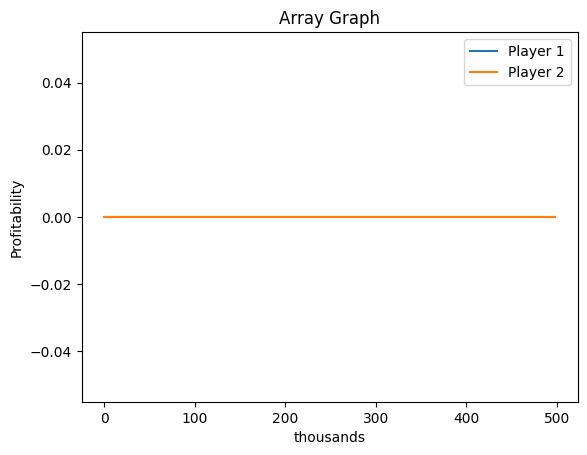

In [31]:
x_values = range(len(avg_prof1))

# Plot the array as a line graph
plt.plot(x_values, avg_prof1)
plt.plot(x_values, avg_prof2)

# Add labels and title
plt.xlabel('thousands')
plt.ylabel('Profitability')
plt.title('Array Graph')
plt.legend(['Player 1', 'Player 2'])

# Display the graph
plt.show()